In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
import umap.umap_ as umap

random_state = 1000

c:\Users\aqfra\miniconda3\envs\test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../data/rock_data.csv')
df.columns

Index(['Sample ID', 'Rock ID', 'Class', 'Orientation', 'Perimeter', 'Area',
       'Axis Major Length', 'Axis Minor Length', 'Mean Height',
       'Median Height', 'Max Height', 'STD Height', 'Mean Gradient',
       'STD Gradient', 'Gradient at Max', 'Weighted Hu Moment 1',
       'Weighted Hu Moment 2', 'Weighted Hu Moment 3', 'Weighted Hu Moment 4'],
      dtype='object')

In [3]:
# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')

In [4]:
print(df['Area'][df['Class']==12].mean())
print(df['Area'][df['Class']==58].mean())
print(df['Area'][df['Class']==34].mean())

360.46310432569976
482.16776315789474
612.5852417302799


In [5]:
# normalize features
df.iloc[:,3:] = df.iloc[:,3:].apply(zscore)

In [6]:
# detect and remove outliers
in_idx = np.ones((len(df),), dtype=bool)

for column in df.columns[3:]:
    n_outliers = sum(abs(zscore(df[column]))>3) 
    in_idx[abs(zscore(df[column]))>3] = False
    
    if n_outliers > 0:
        print(f'Remove {n_outliers} outliers of {column}')
        
df = df.loc[in_idx]

Remove 13 outliers of Perimeter
Remove 12 outliers of Area
Remove 13 outliers of Axis Major Length
Remove 4 outliers of Axis Minor Length
Remove 7 outliers of Mean Height
Remove 9 outliers of Median Height
Remove 5 outliers of Max Height
Remove 5 outliers of STD Height
Remove 14 outliers of Mean Gradient
Remove 13 outliers of STD Gradient
Remove 23 outliers of Gradient at Max
Remove 11 outliers of Weighted Hu Moment 1
Remove 26 outliers of Weighted Hu Moment 2
Remove 18 outliers of Weighted Hu Moment 3
Remove 12 outliers of Weighted Hu Moment 4


For ground-truth clustering, the average silhouette_score = 0.04681254323511719


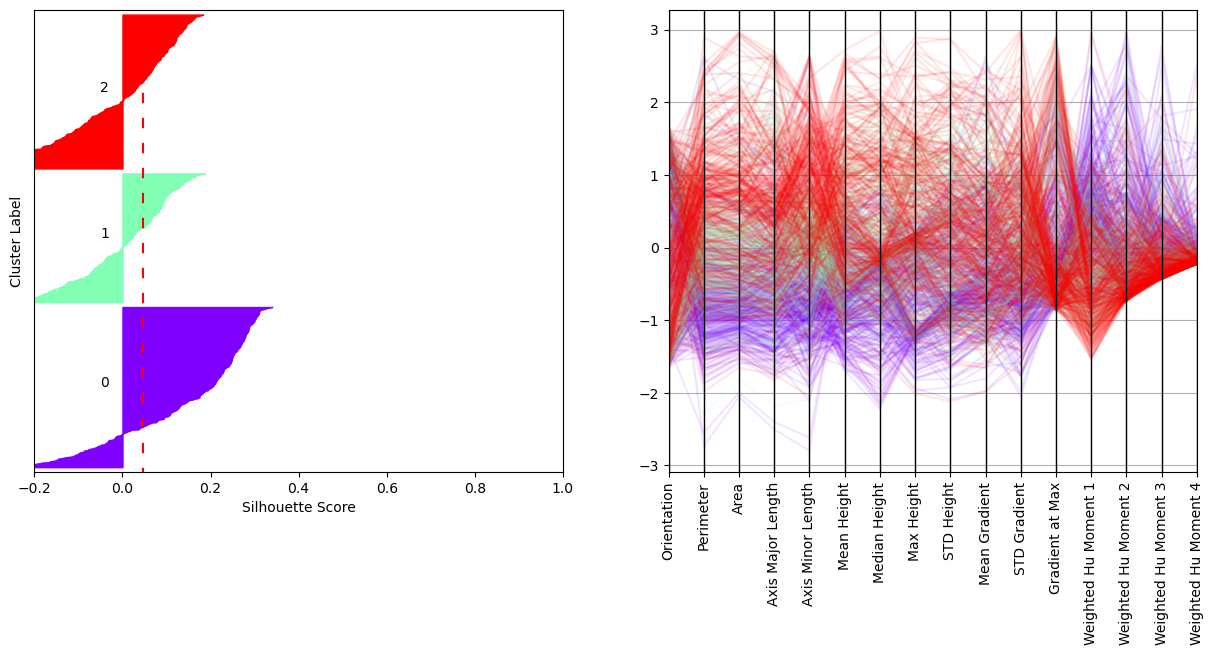

In [7]:
n_clusters = 3
X = df.iloc[:,3:].to_numpy(dtype=float)
df_clustered = df.iloc[:,3:].copy()

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

actual_class = np.vectorize(map_class_values)(df['Class'].values)
df_clustered['cluster'] = actual_class
kmeans_sil = silhouette_score(X, actual_class)
samps_sil = silhouette_samples(X, actual_class)

print(f"For ground-truth clustering, the average silhouette_score = {kmeans_sil}")

fig, axs = subplots(nrows=1, ncols=2, figsize=(15,6))

c_map = cm.rainbow(np.linspace(0, 1, n_clusters))

y_lower = 10
for i in range(n_clusters):
    cluster_sil = np.sort(samps_sil[actual_class == i])
    y_upper = y_lower + cluster_sil.shape[0]

    axs[0].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil, color=c_map[i])

    axs[0].set_xlim([-0.2, 1])
    axs[0].set_ylim([0, len(X) + (n_clusters + 1) * 10])
    axs[0].text(-0.05, y_lower + 0.5 * cluster_sil.shape[0], str(i))

    y_lower = y_upper + 10

axs[0].set_xlabel("Silhouette Score")
axs[0].set_ylabel("Cluster Label")

axs[0].axvline(x=kmeans_sil, color="red", linestyle=(3,(5,7)))

axs[0].set_yticks([])
axs[0].set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

pd.plotting.parallel_coordinates(df_clustered, 'cluster', ax=axs[1], color=c_map, alpha=0.1)
xticks(rotation=90)
axs[1].legend().set_visible(False)

show()

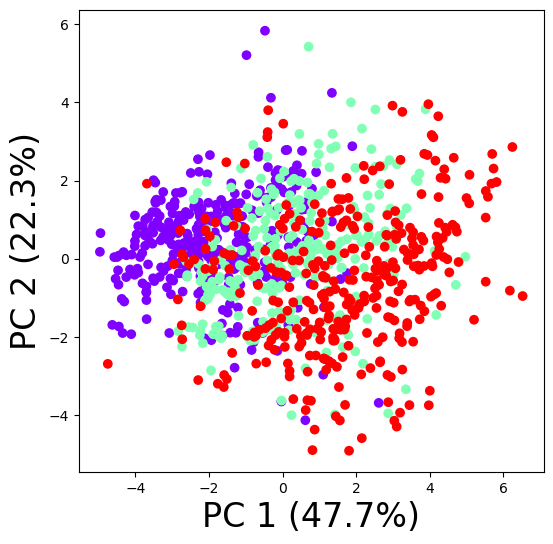

In [8]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig, axs = subplots(nrows=1, ncols=1, figsize=(6,6))

c_map = cm.rainbow(np.linspace(0, 1, n_clusters))
axs.scatter(components[:,0], components[:,1], color=df_clustered['cluster'].map(lambda x: c_map[x]))
axs.set_xlabel(labels['0'], fontsize=24)
axs.set_ylabel(labels['1'], fontsize=24)

show()

In [9]:
sort_idx = np.argsort(-np.abs(pca.components_[0]))
for si in sort_idx:
    print(f'{df.columns[3+si]}: {pca.components_[0][si]}')

Mean Height: 0.3711687806145081
Max Height: 0.3541526983372043
STD Height: 0.3449852625829215
Median Height: 0.3343459051463372
Weighted Hu Moment 1: -0.3008071941179291
STD Gradient: 0.2991613347494899
Perimeter: 0.25898829904548226
Area: 0.25298598103485315
Mean Gradient: 0.24694841212749058
Axis Major Length: 0.24357745551689017
Axis Minor Length: 0.2414261344972687
Weighted Hu Moment 3: -0.09295407931367844
Weighted Hu Moment 2: -0.07786826861825971
Weighted Hu Moment 4: -0.03095205191052827
Orientation: 0.020884210490389386
Gradient at Max: 0.01581415804415557


In [10]:
sort_idx = np.argsort(-np.abs(pca.components_[1]))
for si in sort_idx:
    print(f'{df.columns[3+si]}: {pca.components_[1][si]}')

Area: -0.43054720955218123
Perimeter: -0.4245074826939959
Axis Minor Length: -0.41669810429582704
Axis Major Length: -0.39495443360589877
Mean Gradient: 0.3629104618671077
STD Height: 0.22197027858597213
STD Gradient: 0.2025134099303607
Weighted Hu Moment 1: -0.15121250249516574
Median Height: 0.1279916461845018
Max Height: 0.125936474853264
Mean Height: 0.1153733746755626
Weighted Hu Moment 2: -0.10627379076730996
Weighted Hu Moment 3: -0.03523529877924782
Orientation: 0.02986733699626952
Gradient at Max: 0.022930932479917544
Weighted Hu Moment 4: -0.02093011158743475


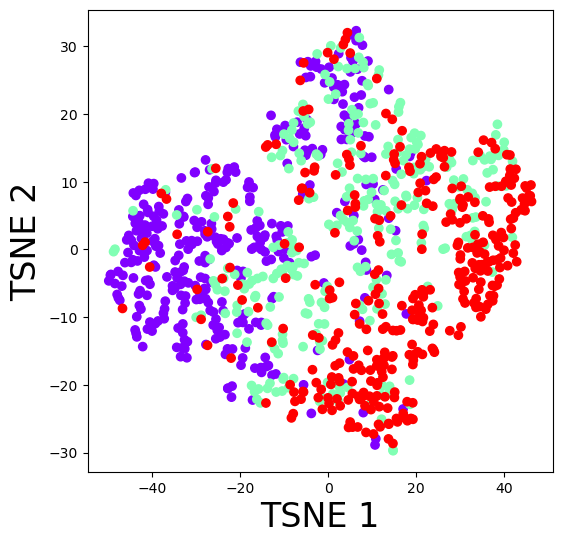

In [11]:
tsne = TSNE(n_components=2)
embedding = tsne.fit_transform(X)
labels = {
    str(i): f"TSNE {i+1}" for i in range(2)
}

fig, axs = subplots(nrows=1, ncols=1, figsize=(6,6))

c_map = cm.rainbow(np.linspace(0, 1, n_clusters))
axs.scatter(embedding[:,0], embedding[:,1], color=df_clustered['cluster'].map(lambda x: c_map[x]))
axs.set_xlabel(labels['0'], fontsize=24)
axs.set_ylabel(labels['1'], fontsize=24)

show()

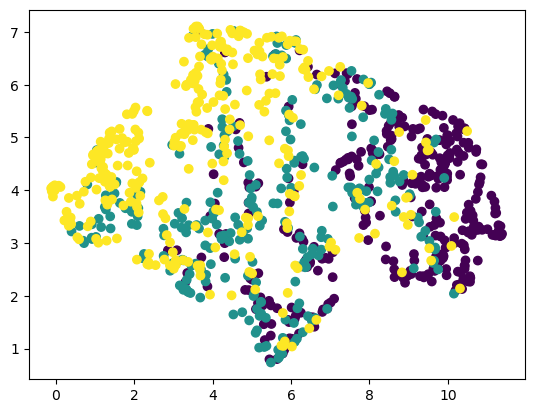

In [12]:
um = umap.UMAP()
embedding = um.fit_transform(X)
scatter(embedding[:, 0], embedding[:, 1], c=df_clustered['cluster'])